[View in Colaboratory](https://colab.research.google.com/github/etienneRiv/deep-grasp/blob/master/Projet_Grasping_Copie_de_Travail_Etienne.ipynb)

# Bibliothèques et Pré-requis

Pour pouvoir être exploité, le jeu de données doit d'abord être sur la machine virtuelle Colab. Ce code est là pour ça. Si vous n'utilisez pas votre machine pendant  un certains temps, elle est recyclée: les fichiers téléchargés ne sont pas gardés. IL faut alors tout recompiler.

In [0]:
!pip install wget
!pip install tqdm 

  Running setup.py bdist_wheel for wget ... - done
  Stored in directory: /content/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget
    100% |████████████████████████████████| 51kB 2.1MB/s 


In [0]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os #pour créer des dossiers
import glob #pour manipuler les noms de fichiers
import wget #pour télécharger des fichiers sur internet
import tarfile, zipfile #pour décompresser des fichiers
import shutil #used for copying files
from tqdm import tqdm #progress bar
from google.colab import files #for downloading/uploading purposes

# Obtention du jeu de données

Le code suivant permet d'extraire les images des grasps labelisés et les stocker.

In [0]:
def process_graspbox(name):
    """Permet d'extraire les points du fichier de labels"""
    f=open(name, 'r')
    graspbox = list(map(
        lambda coordinate: float(coordinate), f.read().strip().split()))    
    return graspbox

In [0]:
def process_rectangles(graspbox):
    """Rassembler chaque rectangle composé de 4 points"""
    rectangles_grasp=[]
    indices_min=[]
    for i in range(0,len(graspbox)):
        if i%8==0:
            NaN=0
            rect=graspbox[i:i+8]
            points=[]
            ind_mini=0
            mini=rect[0]
            for j in range(0,len(rect),2):
                points.append(rect[j:j+2])
                if rect[j]<mini:
                    mini=rect[j]
                    ind_mini=j
            for k in rect:
                if np.isnan(k)==True:
                    NaN=1
            if NaN==0:
                rectangles_grasp.append(points)
                indices_min.append(ind_mini)
    return rectangles_grasp, indices_min

In [0]:
def rotMat2D(angle):
    return [[np.cos(angle),-np.sin(angle)],[np.sin(angle),np.cos(angle)]]

In [0]:
def pointsInAARect(imPoints,rectPoints):
    inRectX=np.not_equal(np.sign(imPoints[:,0] - rectPoints[0][0]),np.sign(imPoints[:,0]-rectPoints[2][0]))
    inRectY=np.not_equal(np.sign(imPoints[:,1] - rectPoints[0][1]),np.sign(imPoints[:,1]-rectPoints[2][1]))
    return np.logical_and(inRectX,inRectY)

In [0]:
def extract_grasp(graspbox,im):
    """ 
    Extract a grasp from an image 'im'. Enter the graspbox(array with the coordinates
    of the four vertices of the gras). The function outputs
    an (n,m,3) array that can then be saved as an image of the grasp.
    This code was in part adapted from a MATLAB code written by
    Ian Lenz and Kevin Lai's from Cornell's Robotics Lab. For practical purposes
    we chose to work with MATLAB's column-major rule to parse arrays. This is why 
    you will see many 'F' arguments.
    """
    rectPoints=graspbox
    im=np.array(im)
    im=im[:,:,:3]
    
    #build an index for each pixel in the image
    t1,t2=np.shape(im)[:2]
    [imX,imY]=np.meshgrid(np.arange(0,t2),np.arange(0,t1))
    imPoints=np.transpose([imX.flatten('F'),imY.flatten('F')])
    
    #find rotation angle and call rotation matrix
    ang=np.arctan2(rectPoints[0][1]-rectPoints[1][1],rectPoints[0][0]-rectPoints[1][0])
    rotMat=rotMat2D(ang)
    
    #rotated graspbox and image index:
    rectPointsRot = np.array(rectPoints) @ np.array(rotMat)
    imPointsRot = np.array(imPoints)@ np.array(rotMat)
    
    #determine if a pixel is inside the graspbox
    #and build a truth matrix to identify those inside
    inRect = pointsInAARect(imPointsRot,rectPointsRot)
    
    #keep only relevant pixels
    newPoints=imPointsRot[inRect]
    
    #turn the rotated image index of the pixels inside
    #the matrix into a coordinate system
    newPoints=newPoints-[newPoints[:,0].min(),newPoints[:,1].min()]
    
    #create an array the size of the grasp
    I2=np.zeros([int(np.around(newPoints[:,1].max())),int(np.around(newPoints[:,0].max())),3])
    
    newPoints=np.uint32(np.around(newPoints))
    
    #for each color in r,g,b:
    for i in range(3):
        #extract the image layer
        channel =im[:,:,i]
        #create a new channel for the output grasp
        newChannel=np.zeros((np.shape(I2)[0],np.shape(I2)[1]))
        
        inRect=np.reshape(inRect,np.shape(im)[:2],'F')
        height,length= np.shape(im)[:2]
        
        #fill the output grasp layer with the correct pixels
        l=0
        k=0
        for j in range(len(newPoints)):
            while inRect[k][l] ==False and l<=length:
                k=k+1
                if k==height:
                    k=0
                    l=l+1
        
            newChannel[newPoints[j][1]-1,newPoints[j][0]-1]= int(channel[k][l])
            k=k+1
            if k==height:
                k=0
                l=l+1
                
        I2[:,:,i]=newChannel
        
    I2=I2.astype(np.uint8)
    grasp_image = Image.fromarray(I2)
    return grasp_image

In [0]:
def sub2ind(array_shape, rows, cols):
    return rows+(cols)*array_shape[0]

In [0]:
def extract_grasp2(graspbox,im):
    """ 
    This is an alternative to the previous extract_grasp function. It performs the same
    task. I have not done any benchmarking at this point to determine which is the best,
    but I think this one might be easier to understand.
    
    Extract a grasp from an image 'im'. Enter the graspbox(array with the coordinates
    of the four vertices of the gras). The function outputs
    an (n,m,3) array that can then be saved as an image of the grasp.
    This code was in part adapted from a MATLAB code written by
    Ian Lenz and Kevin Lai's from Cornell's Robotics Lab. For practical purposes
    we chose to work with MATLAB's column-major rule to parse arrays. This is why 
    you will see many 'F' arguments.
    """
    rectPoints=graspbox
    im=np.array(im)
    im=im[:,:,:3]
    
    #build an index for each pixel in the image
    t1,t2=np.shape(im)[:2]
    [imX,imY]=np.meshgrid(np.arange(0,t2),np.arange(0,t1))
    imPoints=np.transpose([imX.flatten('F'),imY.flatten('F')])
    
    #find rotation angle and call rotation matrix
    ang=np.arctan2(rectPoints[0][1]-rectPoints[1][1],rectPoints[0][0]-rectPoints[1][0])
    rotMat=rotMat2D(ang)
    
    #rotated graspbox and image index:
    rectPointsRot = np.array(rectPoints) @ np.array(rotMat)
    imPointsRot = np.array(imPoints)@ np.array(rotMat)
    
    #determine if a pixel is inside the graspbox
    #and build a truth matrix to identify those inside
    inRect = pointsInAARect(imPointsRot,rectPointsRot)
    
    #keep only relevant pixels
    newPoints=imPointsRot[inRect]
    
    #turn the rotated image index of the pixels inside
    #the matrix into a coordinate system
    newPoints=newPoints-[newPoints[:,0].min(),newPoints[:,1].min()]
    
    #create an array the size of the grasp
    I2=np.zeros([int(np.around(newPoints[:,1].max()))+1,int(np.around(newPoints[:,0].max()))+1,3])
    
    newPoints=np.uint32(np.around(newPoints))
    
    #build a linear index both for the location of the pixel in the output and in the source image.
    newInd=[]
    for i in newPoints:
        newInd.append(sub2ind(np.shape(I2),np.uint32(i[1]),np.uint32(i[0])))

    inRect2=[]
    for i in range(len(inRect)):
        if inRect[i]==True:
            inRect2.append(i)
            
    #for each color in r,g,b:
    for i in range(3):
        #extract the image layer
        channel =im[:,:,i]
        #create a new channel for the output grasp
        newChannel=np.zeros((np.shape(I2)[0],np.shape(I2)[1]))
        
        #fill the output grasp layer with the correct pixels
        newChannel[np.unravel_index(newInd,newChannel.shape,'F')] = channel[np.unravel_index(inRect2,channel.shape,'F')]
                
        I2[:,:,i]=newChannel
        
    I2=I2.astype(np.uint8)
    grasp_image = Image.fromarray(I2)
    return grasp_image

In [0]:
def stockage_rect(rect,rect_nb,classe,rootFolder,im_name):
    """Stocker le rectangle dans des sous-dossiers, que la fonction créée s'ils n'existent pas déjà."""
    
    filename=str(classe)+'_'+str(rect_nb)+im_name[:-5]+'.png'
    outputFolder=rootFolder
    if not os.path.exists(outputFolder):
        os.makedirs(outputFolder)
    rect.save(outputFolder +'/'+ filename, "PNG")
    return

In [0]:
def save_labeled_rect(imagefilename, dataFolder, saveFolder, classArray):
    """L'ensemble du process pour UNE image. Renvoi le nombre de rectangles de chaque classe 
    et une array avec la liste ordonnée des classes des rectangles de l'image."""
    os.chdir(dataFolder)
    im = Image.open(imagefilename)
    
    cpos=imagefilename[:-5]+'cpos.txt'
    rects_pos,indices_pos=process_rectangles(process_graspbox(cpos))
    
    cneg=imagefilename[:-5]+'cneg.txt'
    rects_neg,indices_neg=process_rectangles(process_graspbox(cneg))
    
    i,j=0,0
    
    for i in range(len(rects_pos)):
        grasp=extract_grasp(rects_pos[i],im)
        #grasp=extract_grasp2(rects_pos[i],im)
        stockage_rect(grasp,i,1,saveFolder,imagefilename)
        classArray.append(1)
    
    for j in range(len(rects_neg)):
        grasp=extract_grasp(rects_neg[j],im)
        #grasp=extract_grasp2(rects_pos[i],im)
        stockage_rect(grasp,j,0,saveFolder,imagefilename)
        classArray.append(0)
        
    return i,j,classArray

In [0]:
def walkdir(folder):
    """Walk through each files in a directory. Only used for the progress bar
    at this point.
    """
    
    for dirpath, dirs, files in os.walk(folder):
        for filename in files:
            yield os.path.abspath(os.path.join(dirpath, filename))

In [0]:
def process_whole_dataset(dataFolder,saveFolder):
    """Parcours l'ensemble du jeu de donnée sauvée dans dataFolder et extrait tous les rectangles labelisés pour
    les stocker sous forme d'images dans une hierarchie de fichier dont le dossier root est saveFolder. Renvoi la liste
    ordonnée des classes des rectangles sous forme d'array."""
    classArray=[]
    directory = os.fsencode(dataFolder)
    
    filecounter = 0
    for filepath in walkdir(directory):
        filecounter += 1
    
    
    for file in tqdm(os.listdir(directory), total=filecounter,unit="files", leave=False):
        filename = os.fsdecode(file)
        if filename.endswith(".png"): 
            i,j,classArray = save_labeled_rect(filename,dataFolder,saveFolder,classArray)
            continue
        else:
            continue
    return classArray

Le code suivant permet de télécharger la base de données directement sur le site de Cornell, et d'extraire les images zippées et d'obtenir les rectangles de grasps

In [0]:
for i in tqdm(range(10,11)):
  
  if i<10:
    url='http://pr.cs.cornell.edu/grasping/rect_data/temp/data0'+str(i)+'.tar.gz'
    data = wget.download(url)
    Udata= tarfile.open('data0'+str(i)+'.tar.gz','r:gz')
    uncompressed_data=Udata.extractall('/content/CompleteDataset')
    Udata.close()
    listeClasses=process_whole_dataset('/content/CompleteDataset/0'+str(i),'/content/ExtractedDataset/'+str(i))
  
  else:
    url='http://pr.cs.cornell.edu/grasping/rect_data/temp/data10'+'.tar.gz'
    data = wget.download(url)
    Udata= tarfile.open('data10'+'.tar.gz','r:gz')
    uncompressed_data=Udata.extractall('/content/CompleteDataset')
    Udata.close()
    listeClasses=process_whole_dataset('/content/CompleteDataset/10','/content/ExtractedDataset/'+str(i))

print('Done !')


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?files/s]

  1%|          | 1/141 [00:04<10:31,  4.51s/files]

  3%|▎         | 4/141 [00:09<05:34,  2.44s/files]

  6%|▋         | 9/141 [00:14<03:36,  1.64s/files]

 10%|▉         | 14/141 [00:17<02:37,  1.24s/files]

 11%|█         | 15/141 [00:23<03:18,  1.58s/files]

 16%|█▌        | 22/141 [00:27<02:31,  1.27s/files]

 18%|█▊        | 26/141 [00:33<02:28,  1.29s/files]

 25%|██▍       | 35/141 [00:37<01:53,  1.07s/files]

 26%|██▌       | 36/141 [00:41<01:59,  1.14s/files]

 30%|███       | 43/141 [00:45<01:43,  1.05s/files]

 33%|███▎      | 47/141 [00:50<01:40,  1.07s/files]

 35%|███▍      | 49/141 [00:56<01:45,  1.15s/files]

 35%|███▌      | 50/141 [01:01<01:51,  1.22s/files]

 38%|███▊      | 54/141 [01:07<01:48,  1.24s/files]

 44%|████▍     | 62/141 [01:11<01:30,  1.15s/files]

 45%|████▌     | 64/141 [01:16<01:32,  1.20s/files]

 52%|█████▏    | 74/141 [01:22<01:14,  1.11s/files]

 60%|█████▉    | 8



 97%|█████████▋| 137/141 [02:44<00:04,  1.20s/files]

 98%|█████████▊| 138/141 [02:50<00:03,  1.24s/files]

100%|██████████| 141/141 [02:57<00:00,  1.26s/files]


100%|██████████| 1/1 [03:20<00:00, 200.12s/it]


Done !


In [0]:
!du /content/ExtractedDataset #taille du dossier en octets

3260	/content/ExtractedDataset


In [0]:
!ls /content

CompleteDataset  data01.tar (1).gz  data01.tar.gz  datalab  ExtractedDataset


In [0]:
!ls -1 /content/ExtractedDataset | wc -l #nombre de fichiers dans le jeu de données

1071


In [0]:
def make_tarfile(output_dir,output_filename, source_dir):
    os.chdir(output_dir)
    with tarfile.open(output_filename, "w:gz") as tar:
        tar.add(source_dir, arcname=os.path.basename(source_dir))

In [0]:
for i in range(1,11):
  make_tarfile('/content','compressed_grasps_'+str(i)+'.tar.gz','/content/ExtractedDataset/'+str(i))

In [0]:
#Doesn't work on firefox: use Chrome or the Google Drive wrapper at the end of the code
files.download('compressed_grasps_1.tar.gz')

In [0]:
!ls /content

CompleteDataset		     compressed_grasps_8.tar.gz
compressed_grasps_10.tar.gz  compressed_grasps_9.tar.gz
compressed_grasps_1.tar.gz   data01.tar (1).gz
compressed_grasps_2.tar.gz   data01.tar.gz
compressed_grasps_3.tar.gz   data02.tar.gz
compressed_grasps_4.tar.gz   data02.tar.gztnuaswa8.tmp
compressed_grasps_5.tar.gz   datalab
compressed_grasps_6.tar.gz   drive
compressed_grasps_7.tar.gz   ExtractedDataset


In [0]:
# Pour executer le code suivant, il faut avoir créé la connection avec un Google Drive (cf fin du code)
for i in tqdm(range(1,11)):
  shutil.copy('/content/compressed_grasps_'+str(i)+'.tar.gz','/content/drive')


100%|██████████| 10/10 [00:51<00:00,  5.17s/it]


Importer la base de données déjà extraite depuis Google Drive.

In [0]:
!ls /content/drive/'Arts et Métiers'/'PJT Grasping'/'Dataset 20_05 (32d7169a)'

CompleteDataset.zip	  Uncompressed Dataset 20-05.zip
Compressed Dataset 20_05  Uncompressed - Unsorted Dataset 20-05.zip


In [0]:
#import zipped dataset from google drive and extract it. 
#Requires connection with Google Drive (execute the code at the bottom of this notebook)

shutil.copy('/content/drive/Arts et Métiers/PJT Grasping/Dataset 20_05 (32d7169a)/CompleteDataset.zip','/content')

'/content/CompleteDataset.zip'

In [0]:
Udata= zipfile.ZipFile('/content/CompleteDataset.zip','r')
uncompressed_data=Udata.extractall('/content/ExtractedDataset')
Udata.close()

In [0]:
!ls /content/ExtractedDataset

Le code suivant permet de créer les répertoires pour séparer, pour chacune des classes POS et NEG, les échantillons de train / validation / test

In [0]:
original_dataset_dir = '/content/ExtractedDataset'
base_dir = '/content/SeparatedDataset'
if not os.path.exists(base_dir):
  os.mkdir(base_dir)
train_dir = os.path.join(base_dir,'train')
if not os.path.exists(train_dir):
  os.mkdir(train_dir)
validation_dir = os.path.join(base_dir,'validation')
if not os.path.exists(validation_dir):
  os.mkdir(validation_dir)
test_dir = os.path.join(base_dir,'test')
if not os.path.exists(test_dir):
  os.mkdir(test_dir)
train_pos_dir = os.path.join(train_dir,'pos')
if not os.path.exists(train_pos_dir):
  os.mkdir(train_pos_dir)
train_neg_dir = os.path.join(train_dir,'neg')
if not os.path.exists(train_neg_dir):
  os.mkdir(train_neg_dir)
validation_pos_dir = os.path.join(validation_dir,'pos')
if not os.path.exists(validation_pos_dir):
  os.mkdir(validation_pos_dir)
validation_neg_dir = os.path.join(validation_dir,'neg')
if not os.path.exists(validation_neg_dir):
  os.mkdir(validation_neg_dir)
test_pos_dir = os.path.join(test_dir,'pos')
if not os.path.exists(test_pos_dir):
  os.mkdir(test_pos_dir)
test_neg_dir = os.path.join(test_dir,'neg')
if not os.path.exists(test_neg_dir):
  os.mkdir(test_neg_dir)

Répartition des rectangles grasps par classe dans les échantillons train / validation / test

In [0]:
k=0
for name in glob.glob('/content/ExtractedDataset/0_*'):
  name=name[26:]
  if k<2000:
    src=os.path.join(original_dataset_dir, name)
    dst=os.path.join(train_neg_dir, name)
    shutil.copyfile(src,dst)
    k+=1
  elif k>=2000 and k<2500:
    src=os.path.join(original_dataset_dir, name)
    dst=os.path.join(validation_neg_dir, name)
    shutil.copyfile(src,dst)
    k+=1
  elif k>=2500 and k<2900:
    src=os.path.join(original_dataset_dir, name)
    dst=os.path.join(test_neg_dir, name)
    shutil.copyfile(src,dst)
    k+=1

In [0]:
k=0
for name in glob.glob('/content/ExtractedDataset/1_*'):
  name=name[26:]
  if k<2000:
    src=os.path.join(original_dataset_dir, name)
    dst=os.path.join(train_pos_dir, name)
    shutil.copyfile(src,dst)
    k+=1
  elif k>=2000 and k<2500:
    src=os.path.join(original_dataset_dir, name)
    dst=os.path.join(validation_pos_dir, name)
    shutil.copyfile(src,dst)
    k+=1
  elif k>=2500 and k<3000:
    src=os.path.join(original_dataset_dir, name)
    dst=os.path.join(test_pos_dir, name)
    shutil.copyfile(src,dst)
    k+=1

In [0]:
print('total training pos images:', len(os.listdir(train_pos_dir)))
print('total validation pos images:', len(os.listdir(validation_pos_dir)))
print('total test pos images:', len(os.listdir(test_pos_dir)))

print('total training neg images:', len(os.listdir(train_neg_dir)))
print('total validation neg images:', len(os.listdir(validation_neg_dir)))
print('total test neg images:', len(os.listdir(test_neg_dir)))


total training pos images: 2000
total validation pos images: 500
total test pos images: 500
total training neg images: 2000
total validation neg images: 500
total test neg images: 400


# Bibliothèques Deep Learning

In [0]:
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
#from keras.preprocessing import image


# Réseau CNN de base

In [0]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=((50, 50, 3))))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 11, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 9, 128)         73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 2, 2, 128)         147584    
__________

In [0]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [0]:
train_datagen= ImageDataGenerator(rescale=1./255)
test_datagen= ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    target_size=(50,50),
                                                    batch_size=20, 
                                                    class_mode='binary')
validation_generator = train_datagen.flow_from_directory(validation_dir, 
                                                    target_size=(50,50),
                                                    batch_size=20, 
                                                    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [0]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 50, 50, 3)
labels batch shape: (20,)


In [0]:
history = model.fit_generator(
                    train_generator,
                    steps_per_epoch=100,
                    epochs=100,
                    validation_data=validation_generator,
                    validation_steps=50)

Epoch 1/100
100/100 [==============================] - 4s 43ms/step - loss: 0.5963 - acc: 0.7325 - val_loss: 0.4956 - val_acc: 0.7690
Epoch 2/100
100/100 [==============================] - 2s 25ms/step - loss: 0.4143 - acc: 0.8180 - val_loss: 0.3869 - val_acc: 0.8350
Epoch 3/100
100/100 [==============================] - 3s 25ms/step - loss: 0.3425 - acc: 0.8545 - val_loss: 0.3147 - val_acc: 0.8690
Epoch 4/100
100/100 [==============================] - 3s 26ms/step - loss: 0.3021 - acc: 0.8710 - val_loss: 0.2686 - val_acc: 0.9000
Epoch 5/100
100/100 [==============================] - 3s 26ms/step - loss: 0.2863 - acc: 0.8690 - val_loss: 0.2469 - val_acc: 0.9110
Epoch 6/100
100/100 [==============================] - 3s 26ms/step - loss: 0.2693 - acc: 0.8880 - val_loss: 0.3175 - val_acc: 0.8510
Epoch 7/100
 47/100 [=============>................] - ETA: 1s - loss: 0.2555 - acc: 0.8830

100/100 [==============================] - 3s 26ms/step - loss: 0.2505 - acc: 0.8870 - val_loss: 0.2545 - val_acc: 0.8990
Epoch 8/100
100/100 [==============================] - 3s 25ms/step - loss: 0.2483 - acc: 0.8965 - val_loss: 0.2355 - val_acc: 0.9090
Epoch 9/100
100/100 [==============================] - 2s 25ms/step - loss: 0.2426 - acc: 0.8995 - val_loss: 0.2273 - val_acc: 0.9160
Epoch 10/100
100/100 [==============================] - 3s 26ms/step - loss: 0.2345 - acc: 0.9000 - val_loss: 0.2434 - val_acc: 0.9030
Epoch 11/100
100/100 [==============================] - 3s 26ms/step - loss: 0.2273 - acc: 0.9100 - val_loss: 0.2279 - val_acc: 0.9060
Epoch 12/100
100/100 [==============================] - 3s 26ms/step - loss: 0.2201 - acc: 0.9080 - val_loss: 0.2268 - val_acc: 0.9110
Epoch 13/100
 62/100 [=================>............] - ETA: 0s - loss: 0.2215 - acc: 0.9048

100/100 [==============================] - 3s 26ms/step - loss: 0.2149 - acc: 0.9105 - val_loss: 0.2670 - val_acc: 0.8860
Epoch 14/100
100/100 [==============================] - 3s 26ms/step - loss: 0.2040 - acc: 0.9175 - val_loss: 0.1999 - val_acc: 0.9270
Epoch 15/100
100/100 [==============================] - 3s 25ms/step - loss: 0.2030 - acc: 0.9200 - val_loss: 0.2703 - val_acc: 0.8880
Epoch 16/100
100/100 [==============================] - 3s 26ms/step - loss: 0.1976 - acc: 0.9210 - val_loss: 0.1926 - val_acc: 0.9270
Epoch 17/100
100/100 [==============================] - 3s 26ms/step - loss: 0.1846 - acc: 0.9225 - val_loss: 0.2958 - val_acc: 0.8690
Epoch 18/100
100/100 [==============================] - 3s 26ms/step - loss: 0.1805 - acc: 0.9275 - val_loss: 0.1860 - val_acc: 0.9260
Epoch 19/100
 65/100 [==================>...........] - ETA: 0s - loss: 0.1630 - acc: 0.9338

100/100 [==============================] - 3s 26ms/step - loss: 0.1819 - acc: 0.9255 - val_loss: 0.1916 - val_acc: 0.9290
Epoch 20/100
100/100 [==============================] - 3s 26ms/step - loss: 0.1760 - acc: 0.9275 - val_loss: 0.1893 - val_acc: 0.9300
Epoch 21/100
100/100 [==============================] - 3s 27ms/step - loss: 0.1691 - acc: 0.9315 - val_loss: 0.1988 - val_acc: 0.9230
Epoch 22/100
100/100 [==============================] - 3s 26ms/step - loss: 0.1662 - acc: 0.9370 - val_loss: 0.1947 - val_acc: 0.9300
Epoch 23/100
100/100 [==============================] - 3s 27ms/step - loss: 0.1573 - acc: 0.9335 - val_loss: 0.2074 - val_acc: 0.9190
Epoch 24/100
100/100 [==============================] - 3s 27ms/step - loss: 0.1549 - acc: 0.9380 - val_loss: 0.2041 - val_acc: 0.9220
Epoch 25/100
 46/100 [============>.................] - ETA: 1s - loss: 0.1548 - acc: 0.9348

100/100 [==============================] - 3s 25ms/step - loss: 0.1490 - acc: 0.9395 - val_loss: 0.2722 - val_acc: 0.8850
Epoch 26/100
100/100 [==============================] - 3s 27ms/step - loss: 0.1539 - acc: 0.9415 - val_loss: 0.1956 - val_acc: 0.9290
Epoch 27/100
100/100 [==============================] - 3s 26ms/step - loss: 0.1391 - acc: 0.9420 - val_loss: 0.1845 - val_acc: 0.9300
Epoch 28/100
100/100 [==============================] - 3s 26ms/step - loss: 0.1374 - acc: 0.9435 - val_loss: 0.1820 - val_acc: 0.9310
Epoch 29/100
100/100 [==============================] - 3s 26ms/step - loss: 0.1329 - acc: 0.9410 - val_loss: 0.1766 - val_acc: 0.9350
Epoch 30/100
100/100 [==============================] - 3s 26ms/step - loss: 0.1276 - acc: 0.9510 - val_loss: 0.1965 - val_acc: 0.9280
Epoch 31/100
 62/100 [=================>............] - ETA: 0s - loss: 0.1079 - acc: 0.9548

100/100 [==============================] - 3s 25ms/step - loss: 0.1241 - acc: 0.9505 - val_loss: 0.1822 - val_acc: 0.9290
Epoch 32/100
100/100 [==============================] - 3s 26ms/step - loss: 0.1094 - acc: 0.9595 - val_loss: 0.1936 - val_acc: 0.9260
Epoch 33/100
100/100 [==============================] - 3s 25ms/step - loss: 0.1110 - acc: 0.9595 - val_loss: 0.1863 - val_acc: 0.9300
Epoch 34/100
100/100 [==============================] - 3s 26ms/step - loss: 0.1135 - acc: 0.9575 - val_loss: 0.1796 - val_acc: 0.9300
Epoch 35/100
100/100 [==============================] - 3s 26ms/step - loss: 0.1050 - acc: 0.9610 - val_loss: 0.2018 - val_acc: 0.9250
Epoch 36/100
100/100 [==============================] - 2s 25ms/step - loss: 0.0982 - acc: 0.9655 - val_loss: 0.1791 - val_acc: 0.9290
Epoch 37/100
 65/100 [==================>...........] - ETA: 0s - loss: 0.0876 - acc: 0.9662

100/100 [==============================] - 2s 25ms/step - loss: 0.0903 - acc: 0.9640 - val_loss: 0.2069 - val_acc: 0.9270
Epoch 38/100
100/100 [==============================] - 3s 26ms/step - loss: 0.0919 - acc: 0.9705 - val_loss: 0.1858 - val_acc: 0.9250
Epoch 39/100
100/100 [==============================] - 3s 26ms/step - loss: 0.0818 - acc: 0.9685 - val_loss: 0.1971 - val_acc: 0.9270
Epoch 40/100
100/100 [==============================] - 3s 26ms/step - loss: 0.0805 - acc: 0.9725 - val_loss: 0.1859 - val_acc: 0.9320
Epoch 41/100
100/100 [==============================] - 2s 25ms/step - loss: 0.0737 - acc: 0.9725 - val_loss: 0.2594 - val_acc: 0.9060
Epoch 42/100
100/100 [==============================] - 2s 25ms/step - loss: 0.0771 - acc: 0.9720 - val_loss: 0.2024 - val_acc: 0.9300
Epoch 43/100
 68/100 [===================>..........] - ETA: 0s - loss: 0.0661 - acc: 0.9750

100/100 [==============================] - 3s 26ms/step - loss: 0.0683 - acc: 0.9730 - val_loss: 0.1935 - val_acc: 0.9340
Epoch 44/100
100/100 [==============================] - 3s 26ms/step - loss: 0.0695 - acc: 0.9780 - val_loss: 0.1979 - val_acc: 0.9330
Epoch 45/100
100/100 [==============================] - 2s 25ms/step - loss: 0.0561 - acc: 0.9825 - val_loss: 0.2814 - val_acc: 0.9080
Epoch 46/100
100/100 [==============================] - 3s 25ms/step - loss: 0.0564 - acc: 0.9810 - val_loss: 0.2044 - val_acc: 0.9290
Epoch 47/100
100/100 [==============================] - 3s 26ms/step - loss: 0.0517 - acc: 0.9825 - val_loss: 0.2449 - val_acc: 0.9170
Epoch 48/100
100/100 [==============================] - 3s 27ms/step - loss: 0.0539 - acc: 0.9820 - val_loss: 0.2132 - val_acc: 0.9300
Epoch 49/100
 63/100 [=================>............] - ETA: 0s - loss: 0.0507 - acc: 0.9849

100/100 [==============================] - 3s 26ms/step - loss: 0.0505 - acc: 0.9860 - val_loss: 0.2075 - val_acc: 0.9300
Epoch 50/100
100/100 [==============================] - 3s 26ms/step - loss: 0.0405 - acc: 0.9890 - val_loss: 0.2232 - val_acc: 0.9250
Epoch 51/100
100/100 [==============================] - 3s 26ms/step - loss: 0.0392 - acc: 0.9865 - val_loss: 0.2246 - val_acc: 0.9330
Epoch 52/100
100/100 [==============================] - 3s 25ms/step - loss: 0.0370 - acc: 0.9900 - val_loss: 0.2437 - val_acc: 0.9280
Epoch 53/100
100/100 [==============================] - 3s 25ms/step - loss: 0.0361 - acc: 0.9890 - val_loss: 0.2260 - val_acc: 0.9330
Epoch 54/100
100/100 [==============================] - 2s 25ms/step - loss: 0.0279 - acc: 0.9910 - val_loss: 0.2640 - val_acc: 0.9230
Epoch 55/100
 62/100 [=================>............] - ETA: 0s - loss: 0.0279 - acc: 0.9960

100/100 [==============================] - 3s 26ms/step - loss: 0.0230 - acc: 0.9965 - val_loss: 0.2427 - val_acc: 0.9320
Epoch 56/100
100/100 [==============================] - 3s 25ms/step - loss: 0.0276 - acc: 0.9930 - val_loss: 0.2943 - val_acc: 0.9240
Epoch 57/100
100/100 [==============================] - 3s 25ms/step - loss: 0.0273 - acc: 0.9920 - val_loss: 0.2416 - val_acc: 0.9280
Epoch 58/100
100/100 [==============================] - 3s 26ms/step - loss: 0.0235 - acc: 0.9935 - val_loss: 0.2880 - val_acc: 0.9200
Epoch 59/100
100/100 [==============================] - 2s 25ms/step - loss: 0.0213 - acc: 0.9940 - val_loss: 0.2526 - val_acc: 0.9310
Epoch 60/100
100/100 [==============================] - 2s 24ms/step - loss: 0.0192 - acc: 0.9935 - val_loss: 0.2849 - val_acc: 0.9210
Epoch 61/100
 65/100 [==================>...........] - ETA: 0s - loss: 0.0187 - acc: 0.9946

100/100 [==============================] - 2s 25ms/step - loss: 0.0178 - acc: 0.9950 - val_loss: 0.2789 - val_acc: 0.9260
Epoch 62/100
100/100 [==============================] - 2s 25ms/step - loss: 0.0210 - acc: 0.9935 - val_loss: 0.2740 - val_acc: 0.9310
Epoch 63/100
100/100 [==============================] - 3s 26ms/step - loss: 0.0170 - acc: 0.9945 - val_loss: 0.2790 - val_acc: 0.9260
Epoch 64/100
100/100 [==============================] - 3s 26ms/step - loss: 0.0133 - acc: 0.9960 - val_loss: 0.2853 - val_acc: 0.9290
Epoch 65/100
100/100 [==============================] - 3s 26ms/step - loss: 0.0126 - acc: 0.9955 - val_loss: 0.5134 - val_acc: 0.8960
Epoch 66/100
100/100 [==============================] - 3s 26ms/step - loss: 0.0134 - acc: 0.9960 - val_loss: 0.2775 - val_acc: 0.9380
Epoch 67/100
 66/100 [==================>...........] - ETA: 0s - loss: 0.0083 - acc: 0.9992

100/100 [==============================] - 2s 24ms/step - loss: 0.0085 - acc: 0.9990 - val_loss: 0.3191 - val_acc: 0.9350
Epoch 68/100
100/100 [==============================] - 2s 25ms/step - loss: 0.0100 - acc: 0.9990 - val_loss: 0.3260 - val_acc: 0.9290
Epoch 69/100
100/100 [==============================] - 2s 24ms/step - loss: 0.0185 - acc: 0.9920 - val_loss: 0.4457 - val_acc: 0.9140
Epoch 70/100
100/100 [==============================] - 2s 24ms/step - loss: 0.0085 - acc: 0.9970 - val_loss: 0.3186 - val_acc: 0.9330
Epoch 71/100
100/100 [==============================] - 3s 25ms/step - loss: 0.0079 - acc: 0.9980 - val_loss: 0.3664 - val_acc: 0.9220
Epoch 72/100
100/100 [==============================] - 3s 26ms/step - loss: 0.0056 - acc: 0.9985 - val_loss: 0.4673 - val_acc: 0.9090
Epoch 73/100
 65/100 [==================>...........] - ETA: 0s - loss: 0.0093 - acc: 0.9977

100/100 [==============================] - 2s 25ms/step - loss: 0.0075 - acc: 0.9985 - val_loss: 0.4447 - val_acc: 0.9210
Epoch 74/100
100/100 [==============================] - 3s 26ms/step - loss: 0.0088 - acc: 0.9970 - val_loss: 0.3577 - val_acc: 0.9270
Epoch 75/100
100/100 [==============================] - 3s 26ms/step - loss: 0.0025 - acc: 1.0000 - val_loss: 0.3840 - val_acc: 0.9280
Epoch 76/100
100/100 [==============================] - 3s 25ms/step - loss: 0.0094 - acc: 0.9965 - val_loss: 0.3684 - val_acc: 0.9360
Epoch 77/100
100/100 [==============================] - 3s 26ms/step - loss: 0.0035 - acc: 0.9995 - val_loss: 0.3641 - val_acc: 0.9300
Epoch 78/100
100/100 [==============================] - 3s 27ms/step - loss: 0.0124 - acc: 0.9950 - val_loss: 0.3522 - val_acc: 0.9320
Epoch 79/100
 58/100 [================>.............] - ETA: 0s - loss: 7.3519e-04 - acc: 1.0000

100/100 [==============================] - 3s 26ms/step - loss: 0.0026 - acc: 0.9995 - val_loss: 0.3912 - val_acc: 0.9230
Epoch 80/100
100/100 [==============================] - 3s 27ms/step - loss: 0.0096 - acc: 0.9960 - val_loss: 0.3772 - val_acc: 0.9270
Epoch 81/100
100/100 [==============================] - 3s 26ms/step - loss: 0.0053 - acc: 0.9985 - val_loss: 0.4281 - val_acc: 0.9270
Epoch 82/100
100/100 [==============================] - 3s 26ms/step - loss: 0.0034 - acc: 0.9995 - val_loss: 0.3976 - val_acc: 0.9320
Epoch 83/100
100/100 [==============================] - 3s 26ms/step - loss: 0.0069 - acc: 0.9980 - val_loss: 0.3557 - val_acc: 0.9320
Epoch 84/100
100/100 [==============================] - 3s 26ms/step - loss: 0.0054 - acc: 0.9985 - val_loss: 0.4258 - val_acc: 0.9320
Epoch 85/100
 61/100 [=================>............] - ETA: 0s - loss: 6.2612e-04 - acc: 1.0000

100/100 [==============================] - 2s 24ms/step - loss: 0.0038 - acc: 0.9990 - val_loss: 0.3911 - val_acc: 0.9290
Epoch 86/100
100/100 [==============================] - 3s 26ms/step - loss: 0.0034 - acc: 0.9995 - val_loss: 0.3971 - val_acc: 0.9290
Epoch 87/100
100/100 [==============================] - 2s 25ms/step - loss: 0.0051 - acc: 0.9985 - val_loss: 0.4146 - val_acc: 0.9310
Epoch 88/100
100/100 [==============================] - 3s 26ms/step - loss: 0.0060 - acc: 0.9990 - val_loss: 0.4156 - val_acc: 0.9310
Epoch 89/100
100/100 [==============================] - 3s 26ms/step - loss: 0.0018 - acc: 0.9995 - val_loss: 0.4117 - val_acc: 0.9320
Epoch 90/100
100/100 [==============================] - 3s 26ms/step - loss: 0.0120 - acc: 0.9980 - val_loss: 0.4474 - val_acc: 0.9190
Epoch 91/100
 62/100 [=================>............] - ETA: 0s - loss: 4.6070e-04 - acc: 1.0000

100/100 [==============================] - 3s 25ms/step - loss: 0.0010 - acc: 1.0000 - val_loss: 0.4099 - val_acc: 0.9360
Epoch 92/100
100/100 [==============================] - 3s 26ms/step - loss: 0.0025 - acc: 0.9995 - val_loss: 0.4376 - val_acc: 0.9350
Epoch 93/100
100/100 [==============================] - 3s 26ms/step - loss: 0.0017 - acc: 0.9995 - val_loss: 0.4613 - val_acc: 0.9290
Epoch 94/100
100/100 [==============================] - 3s 25ms/step - loss: 0.0064 - acc: 0.9990 - val_loss: 0.5976 - val_acc: 0.9100
Epoch 95/100
100/100 [==============================] - 3s 26ms/step - loss: 0.0031 - acc: 0.9990 - val_loss: 0.4584 - val_acc: 0.9350
Epoch 96/100
100/100 [==============================] - 3s 26ms/step - loss: 0.0056 - acc: 0.9995 - val_loss: 0.4388 - val_acc: 0.9310
Epoch 97/100
 61/100 [=================>............] - ETA: 0s - loss: 0.0071 - acc: 0.9992

100/100 [==============================] - 3s 26ms/step - loss: 0.0044 - acc: 0.9995 - val_loss: 0.6632 - val_acc: 0.9090
Epoch 98/100
100/100 [==============================] - 3s 26ms/step - loss: 0.0041 - acc: 0.9980 - val_loss: 0.4942 - val_acc: 0.9250
Epoch 99/100
100/100 [==============================] - 2s 25ms/step - loss: 0.0059 - acc: 0.9985 - val_loss: 0.4932 - val_acc: 0.9210
Epoch 100/100
100/100 [==============================] - 2s 24ms/step - loss: 0.0092 - acc: 0.9985 - val_loss: 0.5098 - val_acc: 0.9250


In [0]:
model.save('base_20_05.h5')

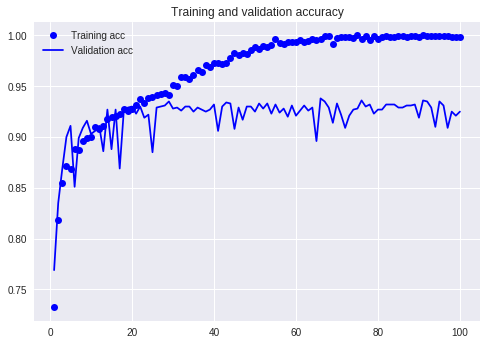

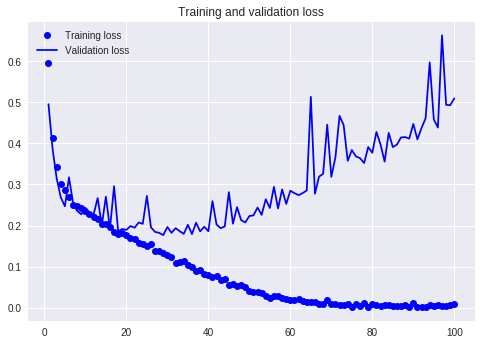

In [0]:
import matplotlib.pyplot as plt

acc=history.history['acc']
val_acc = history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Réseau CNN avec Data Augmentation

Pas forcément une très bonne idée finalement, on perd la géométrie des grasps dans certains cas. Peut_être est-il pertinent de réduir le data augmentation à quelques transformations basiques.

In [0]:
datagen = ImageDataGenerator(
      rotation_range=90,
      horizontal_flip=True,
      fill_mode='constant',
    cval=0)

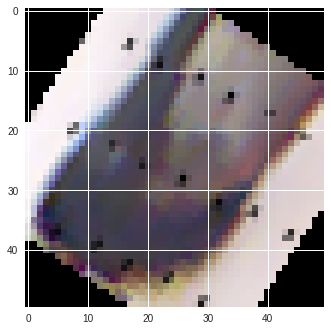

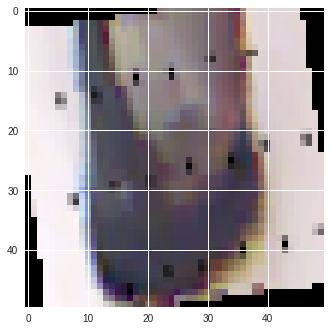

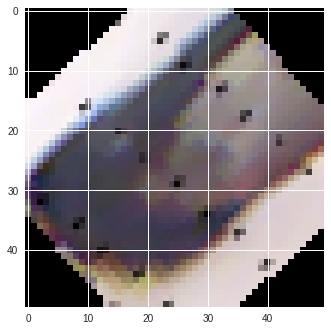

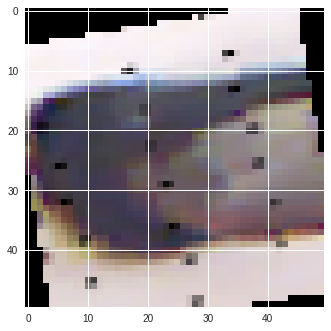

In [0]:
# This is module with image preprocessing utilities
from keras.preprocessing import image

fnames = [os.path.join(train_pos_dir, fname) for fname in os.listdir(train_pos_dir)]

# We pick one image to "augment"
img_path = fnames[200]

# Read the image and resize it
img = image.load_img(img_path, target_size=(50, 50))

# Convert it to a Numpy array with shape (150, 150, 3)
x = image.img_to_array(img)

# Reshape it to (1, 150, 150, 3)
x = x.reshape((1,) + x.shape)

# The .flow() command below generates batches of randomly transformed images.
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

In [0]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(50, 50, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 48, 48, 32)        896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 22, 22, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 11, 11, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 9, 9, 128)         73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 2, 2, 128)         147584    
__________

In [0]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
      rotation_range=90,
      horizontal_flip=True,
      fill_mode='constant',
    cval=0)

test_datagen = ImageDataGenerator(rescale=1./255)

In [0]:
train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(50, 50),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(50, 50),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

Found 4000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.


In [0]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/30
100/100 [==============================] - 6s 59ms/step - loss: 0.6906 - acc: 0.5235 - val_loss: 0.6905 - val_acc: 0.5000
Epoch 2/30
100/100 [==============================] - 4s 44ms/step - loss: 0.6841 - acc: 0.5590 - val_loss: 0.6804 - val_acc: 0.6260
Epoch 3/30
100/100 [==============================] - 4s 43ms/step - loss: 0.6797 - acc: 0.5715 - val_loss: 0.6677 - val_acc: 0.5830
Epoch 4/30
100/100 [==============================] - 4s 42ms/step - loss: 0.6715 - acc: 0.5800 - val_loss: 0.6529 - val_acc: 0.6240
Epoch 5/30
100/100 [==============================] - 4s 41ms/step - loss: 0.6599 - acc: 0.6185 - val_loss: 0.6427 - val_acc: 0.6470
Epoch 6/30
 36/100 [=========>....................] - ETA: 1s - loss: 0.6688 - acc: 0.6042

100/100 [==============================] - 4s 43ms/step - loss: 0.6546 - acc: 0.6115 - val_loss: 0.6506 - val_acc: 0.6270
Epoch 7/30
100/100 [==============================] - 4s 41ms/step - loss: 0.6453 - acc: 0.6290 - val_loss: 0.6475 - val_acc: 0.6370
Epoch 8/30
100/100 [==============================] - 4s 42ms/step - loss: 0.6436 - acc: 0.6365 - val_loss: 0.6259 - val_acc: 0.6610
Epoch 9/30
100/100 [==============================] - 4s 41ms/step - loss: 0.6406 - acc: 0.6430 - val_loss: 0.6277 - val_acc: 0.6550
Epoch 10/30
100/100 [==============================] - 4s 41ms/step - loss: 0.6512 - acc: 0.6180 - val_loss: 0.6182 - val_acc: 0.6670
Epoch 11/30
 45/100 [============>.................] - ETA: 1s - loss: 0.6276 - acc: 0.6378

100/100 [==============================] - 4s 42ms/step - loss: 0.6359 - acc: 0.6315 - val_loss: 0.6236 - val_acc: 0.6570
Epoch 12/30
100/100 [==============================] - 4s 41ms/step - loss: 0.6414 - acc: 0.6335 - val_loss: 0.6182 - val_acc: 0.6600
Epoch 13/30
100/100 [==============================] - 4s 41ms/step - loss: 0.6258 - acc: 0.6560 - val_loss: 0.6168 - val_acc: 0.6630
Epoch 14/30
100/100 [==============================] - 4s 40ms/step - loss: 0.6398 - acc: 0.6320 - val_loss: 0.5973 - val_acc: 0.6870
Epoch 15/30
100/100 [==============================] - 4s 40ms/step - loss: 0.6271 - acc: 0.6570 - val_loss: 0.5947 - val_acc: 0.6860
Epoch 16/30
 31/100 [========>.....................] - ETA: 1s - loss: 0.6371 - acc: 0.6323

100/100 [==============================] - 4s 41ms/step - loss: 0.6410 - acc: 0.6415 - val_loss: 0.5890 - val_acc: 0.7090
Epoch 17/30
100/100 [==============================] - 4s 41ms/step - loss: 0.6335 - acc: 0.6380 - val_loss: 0.5954 - val_acc: 0.6840
Epoch 18/30
100/100 [==============================] - 4s 41ms/step - loss: 0.6230 - acc: 0.6565 - val_loss: 0.6034 - val_acc: 0.6610
Epoch 19/30
100/100 [==============================] - 4s 40ms/step - loss: 0.6206 - acc: 0.6545 - val_loss: 0.5739 - val_acc: 0.7110
Epoch 20/30
100/100 [==============================] - 4s 40ms/step - loss: 0.6257 - acc: 0.6605 - val_loss: 0.5858 - val_acc: 0.7040
Epoch 21/30
 33/100 [========>.....................] - ETA: 1s - loss: 0.6141 - acc: 0.6652

100/100 [==============================] - 4s 40ms/step - loss: 0.6171 - acc: 0.6635 - val_loss: 0.5932 - val_acc: 0.6780
Epoch 22/30
100/100 [==============================] - 4s 40ms/step - loss: 0.6310 - acc: 0.6565 - val_loss: 0.5929 - val_acc: 0.6790
Epoch 23/30
100/100 [==============================] - 4s 40ms/step - loss: 0.6287 - acc: 0.6540 - val_loss: 0.6849 - val_acc: 0.6100
Epoch 24/30
100/100 [==============================] - 4s 39ms/step - loss: 0.6122 - acc: 0.6650 - val_loss: 0.5904 - val_acc: 0.6980
Epoch 25/30
100/100 [==============================] - 4s 40ms/step - loss: 0.6090 - acc: 0.6840 - val_loss: 0.5762 - val_acc: 0.7040
Epoch 26/30
 36/100 [=========>....................] - ETA: 1s - loss: 0.6022 - acc: 0.6750

100/100 [==============================] - 4s 40ms/step - loss: 0.6101 - acc: 0.6620 - val_loss: 0.5943 - val_acc: 0.6890
Epoch 27/30
100/100 [==============================] - 4s 39ms/step - loss: 0.6092 - acc: 0.6770 - val_loss: 0.6081 - val_acc: 0.6700
Epoch 28/30
100/100 [==============================] - 4s 40ms/step - loss: 0.6077 - acc: 0.6710 - val_loss: 0.5877 - val_acc: 0.6960
Epoch 29/30
100/100 [==============================] - 4s 40ms/step - loss: 0.6055 - acc: 0.6680 - val_loss: 0.5891 - val_acc: 0.6950
Epoch 30/30
100/100 [==============================] - 4s 41ms/step - loss: 0.5931 - acc: 0.6855 - val_loss: 0.6042 - val_acc: 0.6630


In [0]:
model.save('augmented_angle90_21_05_largeDataset.h5')

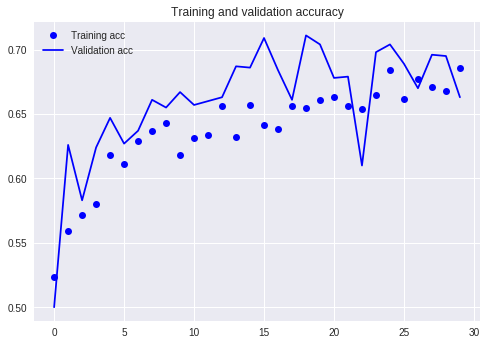

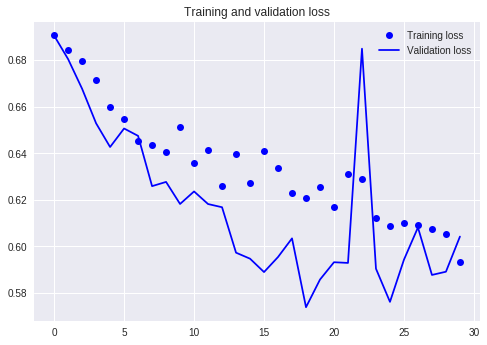

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Ca semble plutot moins bien...

# Réseau Pré-entrainé avec VGG 16 / ImageNet

In [0]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                 include_top=False,
                 input_shape=(50,50,3))

58892288/58889256 [==============================] - 1s 0us/step


## Features extraits puis réinjectés

In [0]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 50, 50, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 50, 50, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 50, 50, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 25, 25, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 25, 25, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 25, 25, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0         
__________

In [0]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
  features = np.zeros(shape=(sample_count, 4, 4, 512))
  labels = np.zeros(shape=(sample_count))
  generator = datagen.flow_from_directory(directory,
                                          target_size=(50, 50),
                                          batch_size=batch_size,
                                          class_mode='binary')
  i = 0
  for inputs_batch, labels_batch in generator:
    features_batch = conv_base.predict(inputs_batch)
    features[i * batch_size : (i + 1) * batch_size] = features_batch
    labels[i * batch_size : (i + 1) * batch_size] = labels_batch
    i += 1
    if i * batch_size >= sample_count:
      break
  return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [0]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [0]:
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 1s 608us/step - loss: 0.4115 - acc: 0.8105 - val_loss: 0.2691 - val_acc: 0.9110
Epoch 2/30
2000/2000 [==============================] - 1s 504us/step - loss: 0.2859 - acc: 0.8815 - val_loss: 0.2305 - val_acc: 0.9150
Epoch 3/30
2000/2000 [==============================] - 1s 544us/step - loss: 0.2607 - acc: 0.8910 - val_loss: 0.2283 - val_acc: 0.9150
Epoch 4/30
2000/2000 [==============================] - 1s 533us/step - loss: 0.2306 - acc: 0.9060 - val_loss: 0.2115 - val_acc: 0.9160
Epoch 5/30
2000/2000 [==============================] - 1s 535us/step - loss: 0.2233 - acc: 0.9045 - val_loss: 0.2079 - val_acc: 0.9160
Epoch 6/30
2000/2000 [==============================] - 1s 532us/step - loss: 0.2189 - acc: 0.9105 - val_loss: 0.2045 - val_acc: 0.9160
Epoch 7/30
2000/2000 [==============================] - 1s 533us/step - loss: 0.2157 - acc: 0.9085 - val_loss: 0.2078 - val_acc: 0.9190


2000/2000 [==============================] - 1s 534us/step - loss: 0.2055 - acc: 0.9150 - val_loss: 0.1999 - val_acc: 0.9140
Epoch 10/30
2000/2000 [==============================] - 1s 525us/step - loss: 0.2041 - acc: 0.9130 - val_loss: 0.2064 - val_acc: 0.9130
Epoch 11/30
2000/2000 [==============================] - 1s 525us/step - loss: 0.1949 - acc: 0.9175 - val_loss: 0.2004 - val_acc: 0.9130
Epoch 12/30
2000/2000 [==============================] - 1s 530us/step - loss: 0.1933 - acc: 0.9215 - val_loss: 0.1988 - val_acc: 0.9180
Epoch 13/30
2000/2000 [==============================] - 1s 520us/step - loss: 0.1949 - acc: 0.9195 - val_loss: 0.1977 - val_acc: 0.9200
Epoch 14/30
2000/2000 [==============================] - 1s 520us/step - loss: 0.1920 - acc: 0.9195 - val_loss: 0.1986 - val_acc: 0.9200
Epoch 15/30
2000/2000 [==============================] - 1s 521us/step - loss: 0.1859 - acc: 0.9250 - val_loss: 0.2000 - val_acc: 0.9170
Epoch 16/30
2000/2000 [==============================

2000/2000 [==============================] - 1s 536us/step - loss: 0.1842 - acc: 0.9290 - val_loss: 0.2007 - val_acc: 0.9180
Epoch 18/30
2000/2000 [==============================] - 1s 527us/step - loss: 0.1787 - acc: 0.9275 - val_loss: 0.1994 - val_acc: 0.9240
Epoch 19/30
2000/2000 [==============================] - 1s 532us/step - loss: 0.1800 - acc: 0.9275 - val_loss: 0.2026 - val_acc: 0.9140
Epoch 20/30
2000/2000 [==============================] - 1s 532us/step - loss: 0.1769 - acc: 0.9270 - val_loss: 0.2012 - val_acc: 0.9180
Epoch 21/30
2000/2000 [==============================] - 1s 527us/step - loss: 0.1719 - acc: 0.9300 - val_loss: 0.2018 - val_acc: 0.9210
Epoch 22/30
2000/2000 [==============================] - 1s 542us/step - loss: 0.1681 - acc: 0.9335 - val_loss: 0.2004 - val_acc: 0.9240
Epoch 23/30
2000/2000 [==============================] - 1s 527us/step - loss: 0.1710 - acc: 0.9315 - val_loss: 0.1987 - val_acc: 0.9240
Epoch 24/30
2000/2000 [==============================

2000/2000 [==============================] - 1s 532us/step - loss: 0.1632 - acc: 0.9340 - val_loss: 0.2000 - val_acc: 0.9180
Epoch 26/30
2000/2000 [==============================] - 1s 523us/step - loss: 0.1633 - acc: 0.9310 - val_loss: 0.2029 - val_acc: 0.9230
Epoch 27/30
2000/2000 [==============================] - 1s 523us/step - loss: 0.1690 - acc: 0.9340 - val_loss: 0.1999 - val_acc: 0.9210
Epoch 28/30
2000/2000 [==============================] - 1s 524us/step - loss: 0.1603 - acc: 0.9395 - val_loss: 0.2025 - val_acc: 0.9210
Epoch 29/30
2000/2000 [==============================] - 1s 523us/step - loss: 0.1607 - acc: 0.9330 - val_loss: 0.2038 - val_acc: 0.9220
Epoch 30/30
2000/2000 [==============================] - 1s 514us/step - loss: 0.1553 - acc: 0.9360 - val_loss: 0.2008 - val_acc: 0.9220


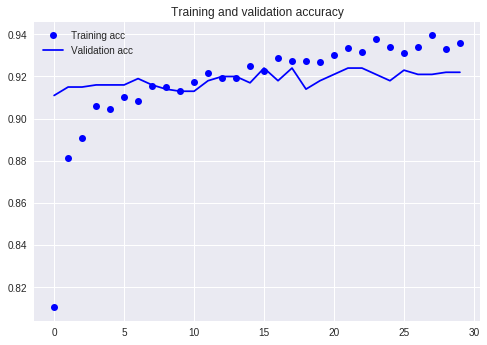

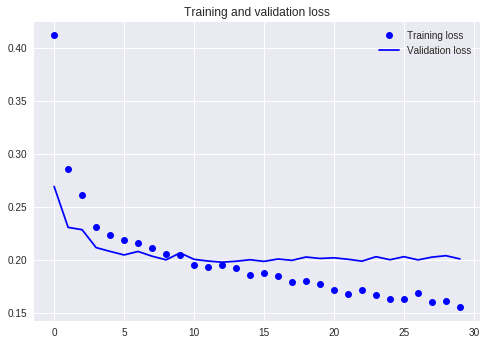

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Réseau dense en bout de VGG 16

Deuixième méthode: réseau dense mis au bout de conv_base. Nous permet d'utiliser le data augmentation

In [0]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 14,846,273
Trainable params: 14,846,273
Non-trainable params: 0
_________________________________________________________________


In [0]:
print('Nombre de poids entrainables',
       len(model.trainable_weights))
conv_base.trainable = False


print('Nombre de poids entrainables après avoir fixé conv_base '
      , len(model.trainable_weights))

Nombre de poids entrainables 30
Nombre de poids entrainables après avoir fixé conv_base  4


In [0]:
"""train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')"""
train_datagen = ImageDataGenerator(rescale=1./255)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(50, 50),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(50, 50),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])


Found 4000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [0]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Epoch 1/30
 - 5s - loss: 0.6596 - acc: 0.6285 - val_loss: 0.6005 - val_acc: 0.7710
Epoch 2/30
 - 4s - loss: 0.5502 - acc: 0.8150 - val_loss: 0.5219 - val_acc: 0.8140
Epoch 3/30
 - 4s - loss: 0.4846 - acc: 0.8335 - val_loss: 0.4651 - val_acc: 0.8240
Epoch 4/30
 - 4s - loss: 0.4285 - acc: 0.8595 - val_loss: 0.4186 - val_acc: 0.8480
Epoch 5/30
 - 4s - loss: 0.3967 - acc: 0.8585 - val_loss: 0.3857 - val_acc: 0.8590
Epoch 6/30
 - 4s - loss: 0.3532 - acc: 0.8815 - val_loss: 0.3596 - val_acc: 0.8670
Epoch 7/30
 - 4s - loss: 0.3376 - acc: 0.8815 - val_loss: 0.3382 - val_acc: 0.8760
Epoch 8/30
 - 4s - loss: 0.3139 - acc: 0.8895 - val_loss: 0.3213 - val_acc: 0.8840
Epoch 9/30
 - 4s - loss: 0.2924 - acc: 0.9000 - val_loss: 0.3086 - val_acc: 0.8860
Epoch 10/30
 - 4s - loss: 0.2971 - acc: 0.8915 - val_loss: 0.2969 - val_acc: 0.9020
Epoch 11/30
 - 4s - loss: 0.2776 - acc: 0.9020 - val_loss: 0.2883 - val_acc: 0.9060
Epoch 12/30
 - 4s - loss: 0.2704 - acc: 0.9010 - val_loss: 0.2807 - val_acc: 0.9080
E

In [0]:
model.save('vgg16_21_05_30epochs_largeDataset.h5')

In [0]:
print(os.getcwd())
!ls

In [0]:
!cp vgg16_21_05_30epochs_largeDataset.h5 /content/drive

Importer un modèle enregistrer déjà sauvé.

In [0]:
!ls

13.jpg		     drive	       vgg16_21_05_30epochs_largeDataset.h5
CompleteDataset.zip  ExtractedDataset
datalab		     SeparatedDataset


In [0]:
from keras.models import load_model
model=load_model('vgg16_21_05_30epochs_largeDataset.h5')

/usr/local/lib/python3.6/dist-packages/keras/models.py:318: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


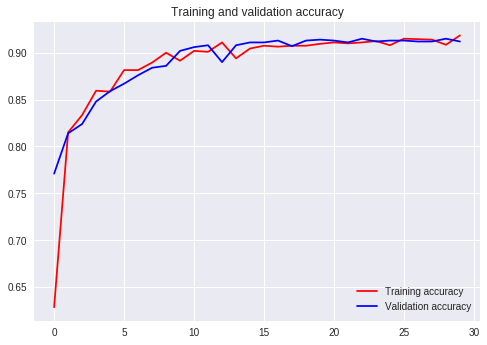

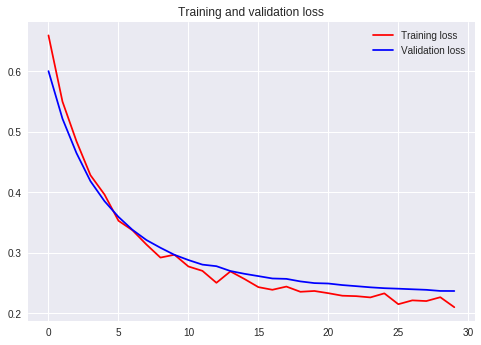

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# Predictions et utilisation du réseau

## Importation d'images

Importer une image à tester. Dans certains cas, soulève une erreur sur firefox. Dans ce ca-là, utilisez chrome.

In [0]:
os.chdir('/content')

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving 13.jpg to 13 (1).jpg
User uploaded file "13.jpg" with length 140586 bytes


## Prediction

In [0]:
!pip install imutils

  Running setup.py bdist_wheel for imutils ... - \ done
  Stored in directory: /content/.cache/pip/wheels/cb/58/9b/7debccbc53159611f67cc7e2e3ed37b217e56e9b40e7ba80c3
Successfully built imutils


In [0]:
from sklearn import feature_extraction as sk
import cv2,imutils
from PIL.ImageDraw import Draw

In [0]:
def center_crop(img,output_size):
    crop_width=output_size[0]/2
    crop_height=output_size[1]/2
    half_the_width = img.size[0] / 2
    half_the_height = img.size[1] / 2
    img_out = img.crop(
    (
        half_the_width - crop_width,
        half_the_height - crop_height,
        half_the_width + crop_width,
        half_the_height + crop_height
    ))
    return img_out

In [0]:
def extract_patch_coord(img_array,patch_size,stride):
    """returns 2 2D arrays: one with all the patches in the image, 
    another with the same chape but filled with the coordinates of the patches in pixels.
    The coordinates correspond to the top left edge of the square patch in the order (horizontal_axis,vertical_axis).
    Requires sklearn.feature_extraction.image and numpy"""
    
    patches_img=sk.image.extract_patches(img_array, patch_size, extraction_step=stride)
    t1,t2=np.shape(patches_img)[:2]
    coordinates=np.zeros((t1,t2,2))
    coordinates[:,:,0],coordinates[:,:,1]=np.meshgrid(np.arange(0,t2*stride,stride),np.arange(0,t1*stride,stride))
    size_array=np.ones(np.shape(patches_img[:2]))*patch_size[0]
    return patches_img, coordinates

In [0]:
def rotated_patch(patch,final_angle,stride):
  patches_rotated=[]
  for angle in np.arange(0, final_angle, stride):
    rotation = imutils.rotate_bound(patch, angle)
    #rotation = imutils.rotate(patch, angle)
    rotation=cv2.resize(rotation,(50,50))
    patches_rotated.append(rotation)
  return patches_rotated

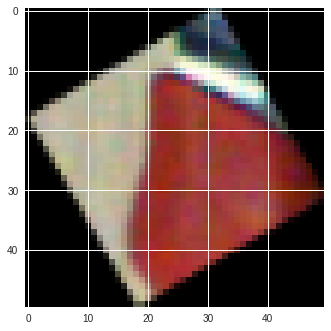

In [0]:
plt.imshow(rot[4])

In [0]:
def find_best_grasp_no_angle(img_filename, patch_size,stride,threshold,crop=True,display=True,crop_size=(400,200)):
  img=Image.open(img_filename)
  if crop==True:
    img=center_crop(img,crop_size)
  img_array= np.asarray(img)[:,:,:3]
  img_array=img_array/255
  patches,coord = extract_patch_coord(img_array,patch_size,stride)
  L=len(patches)
  prediction_all_patches=[]
  potential_grasps=[]
  max_prediction=0
  max_index=0
  max_grasp_coord=0
  threshold=0.6
  for i in range(len(patches)):
    for j in range(len(patches[0])):
      x=patches[i][j]
      c=coord[i][j]
      resized_patch=np.resize(x,(1,)+patch_size)
      prediction=model.predict(resized_patch)
      prediction_all_patches.append(float(prediction))
      if float(prediction) > threshold:
        potential_grasps.append(x)
        if float(prediction)>max_prediction:
            max_prediction=float(prediction)
            max_index=(i,j)
            max_grasp_coord=c
  if  len(potential_grasps)==0:
    print('No grasp found.')
  else:
    print(np.shape(potential_grasps)[0], "potential grasps found.\nThreshold :", threshold)
    print("Max probability: ",max_prediction)
    print("Corresponding Index: ",max_index)
    print("Max coordinates (px): ",max_grasp_coord)
    if display==True:
      plt.imshow(patches[max_index[0]][max_index[1]][0])
      plt.show()
  return patches, potential_grasps, max_prediction, max_index, max_grasp_coord

In [0]:
def display_grasp_on_src_image(img_filename,max_grasp_coord,patch_size,crop=True):
  """Works only for vertical grasps (no patch rotation) for now."""
  img=Image.open(img_filename)
  if crop==True:
    img=center_crop(img,(400,200))
  x_base=max_grasp_coord[0]
  y_base=max_grasp_coord[1]
  img_rect=Draw(img)
  img_rect.rectangle([(x_base,y_base),(x_base+patch_size[0],y_base+patch_size[1])],outline='blue')
  plt.imshow(img)
  plt.show()
  return
  
  

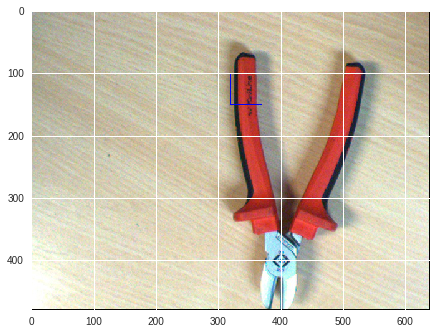

In [0]:
display_grasp_on_src_image("24.jpg",np.uint32(max_grasp_coord),(50,50,3),crop=False)

In [0]:
def find_best_grasp_angle(img_filename, patch_size,stride,final_angle,angle_stride,
                          threshold,crop=True,display=True,crop_size=(400,200)):
  img=Image.open(img_filename)
  if crop==True:
    img=center_crop(img,crop_size)
  img_array= np.asarray(img)[:,:,:3]
  img_array=img_array/255
  patches,coord = extract_patch_coord(img_array,patch_size,stride)
  L=len(patches)
  rotated_patches=np.zeros((np.shape(patches)+(final_angle//angle_stride,)+patch_size))
  for a in range(len(patches)):
    for b in range(len(patches[0])):
      rotated_patches[a][b][:]=rotated_patch(patches[a][b][0],final_angle,angle_stride)  
  prediction_all_patches=[]
  potential_grasps=[]
  max_prediction=0
  max_index=0
  max_grasp_coord=0
  max_angle=0
  for i in tqdm(range(len(rotated_patches))):
    for j in range(len(rotated_patches[0])):
      for k in range(len(rotated_patches[0][0])):
        x=rotated_patches[i][j][k]
        c=coord[i][j]
        angle=k
        resized_patch=np.resize(x,(1,)+patch_size)
        prediction=model.predict(resized_patch)
        prediction_all_patches.append(float(prediction))
        if float(prediction) > threshold:
          potential_grasps.append(x)
          if float(prediction)>max_prediction:
            max_prediction=float(prediction)
            max_index=(i,j)
            max_grasp_coord=c
            max_angle=k
  if  len(potential_grasps)==0:
    print('No grasp found.')
  else:
    print(np.shape(potential_grasps)[0], "potential grasps found.\nThreshold :", threshold)
    print("Max probability: ",max_prediction)
    print("Corresponding Index: ",max_index, max_angle)
    print("Max coordinates (px): ",max_grasp_coord)
    if display==True:
      plt.imshow(rotated_patches[max_index[0]][max_index[1]][0])
      plt.show()
  return rotated_patches, potential_grasps, max_prediction, max_index, max_grasp_coord, max_angle

In [0]:
A=find_best_grasp_angle("13.jpg",(50,50,3),20,0.6,crop=False, display=False)

7 potential grasps found.
Threshold : 0.6
Max probability:  0.6688570380210876
Corresponding Index:  (14, 13) 1
Max coordinates (px):  [260. 280.]


In [0]:
A=find_best_grasp_no_angle("13.jpg",(50,50,3),20,0.6,crop=False, display=False)

9 potential grasps found.
Threshold : 0.6
Max probability:  0.9900835752487183
Corresponding Index:  (16, 22)
Max coordinates (px):  [440. 320.]


In [0]:
rotated_patches, potential_grasps, max_prediction, max_index, max_grasp_coord,max_angle=find_best_grasp_angle("13 (1).jpg",(50,50,3),20,90,15,0.6,crop=False, display=True)

NameError: ignored

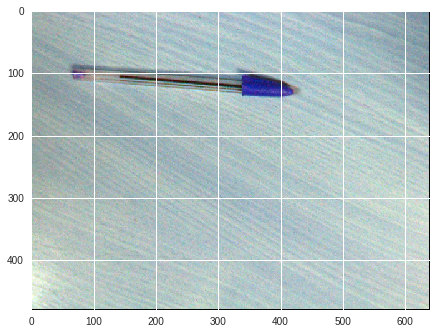

In [0]:
img=Image.open("13 (1).jpg")
plt.imshow(img)

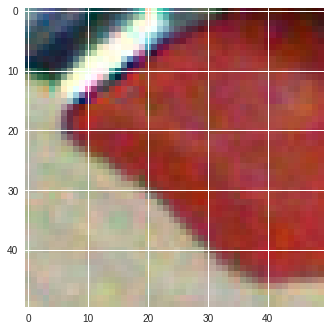

In [0]:
plt.imshow(potential_grasps[3][0])
plt.show()

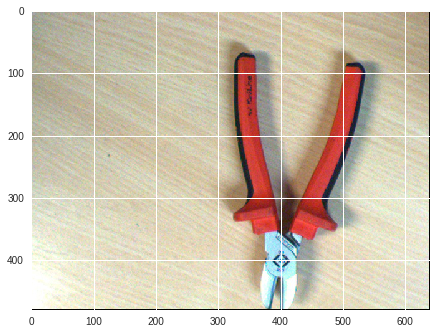

In [0]:
img=Image.open("24.jpg")
plt.imshow(img)

# Importer / Sauver des fichiers depuis Google Drive

Pour ne pas réexecuter l'ensemble du code à chaque fois, on peut sauver le modèle sur un drive google, et simplement le réuploader quand il faut.
On considère avec le programme suivant le drive comme un dossier dans la machine virtuelle.

In [0]:
# Install a Drive FUSE wrapper.
# https://github.com/astrada/google-drive-ocamlfuse
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse



# Generate auth tokens for Colab
from google.colab import auth
auth.authenticate_user()


# Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}


# Create a directory and mount Google Drive using that directory.
!mkdir -p drive
!google-drive-ocamlfuse drive

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
!ls drive

Arts et Métiers  Lycée
BDA		 Obtention de la base de données 2D
BDA 216 - 217	 Perso
Colab Notebooks  Personnages (Théâtre Mardi) .odt
Ginette		 Pictures from SpC18: Global Swarming
Google Photos	 Stages et CVs
Informatique


In [0]:
!ls

base_20_05.h5	     pcd0199r.png
CompleteDataset      SeparatedDataset
CompleteDataset.zip  Uncompressed - Unsorted Dataset 20-05.zip
datalab		     vgg16_20_05_10epochs.h5
drive		     vgg16_20_05_30epochs.h5
ExtractedDataset


In [0]:
!cp base_20_05.h5 /content/drive